# Music-Genre-Classifier Building Deep Learning Model

# 1. Import Dependencies 

In [55]:
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import os 
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np 
import pandas as pd 
import random
import cv2
from tqdm import tqdm
import math
from datetime import datetime
import shutil
import imghdr

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

# Audio Augmentation
from audiomentations import (
    Compose,
    
    TimeStretch, 
    Shift, 
    PitchShift, 
    AddGaussianNoise, 
    ApplyImpulseResponse,
    
    # Filters
    BandPassFilter,
    BandStopFilter,
    HighPassFilter,
    HighShelfFilter,
    LowPassFilter,
    LowShelfFilter, 
    PeakingFilter,
    SevenBandParametricEQ,
    
    PolarityInversion,
    Gain,
    TimeMask,
    SpecFrequencyMask
    
)


# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard

# Image augmentation 
import albumentations as A

##  HyperParamters

In [2]:
DATA_DIR = os.path.join('data', 'Data','genres_original')
CLASSES = os.listdir(DATA_DIR)

DATA_GEN_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATA_GEN_DIR, 'train')
TEST_DIR = os.path.join(DATA_GEN_DIR, 'test')
VALIDATE_DIR = os.path.join(DATA_GEN_DIR, 'validation')

AUGMENTATION_MULTIPLIER = 10
AUGMENTATION_IMPULSE_PATH = 'ir'

EXAMPLE_FILE = os.path.join(DATA_DIR,'blues', 'blues.00000.wav') 
CLASSES

['reggae',
 'metal',
 'disco',
 'pop',
 'blues',
 'hiphop',
 'classical',
 'rock',
 'country',
 'jazz']

# 2. Data Pre-Processing

📌  **2.0 Data Exploration**  
📌  **2.1 Data Splitting**  
📌  **2.2 Data Data Augmentation**  
📌  **2.3 Build Dataloading Function**  

## 2.0 Data exploration


* **Sound:** sequence of vibrations in varying pressure strengths (y)
* The **sample rate (sr)** is the number of samples of audio carried per second, measured in Hz or kHz


In [3]:
y, sr = librosa.load(EXAMPLE_FILE)

print('y:', y)
print('y shape:', np.shape(y))
print('Sample Rate (KHz):', sr)
# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
y shape: (661794,)
Sample Rate (KHz): 22050
Check Len of Audio: 30.013333333333332


In [4]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)
# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] 

Audio File shape: (661794,)


2D Representation: Sound Waves

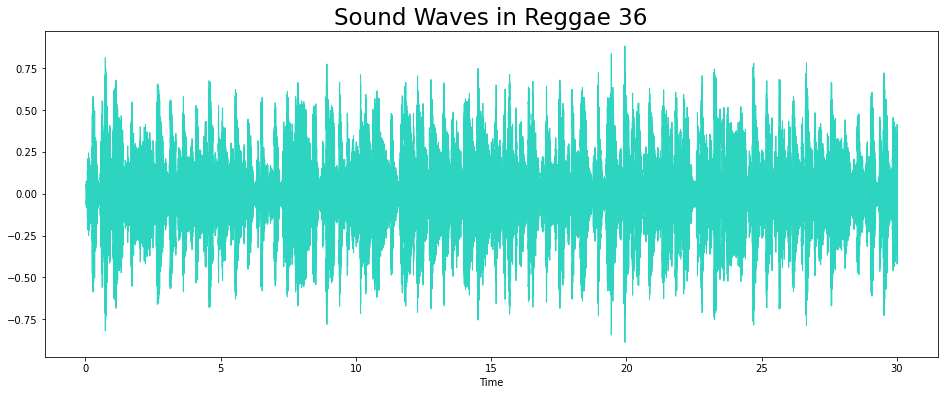

In [5]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#2dd4bf");
plt.title("Sound Waves in Reggae 36", fontsize = 23);


Fourier Transform

* Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
* Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.



Shape of D object: (1025, 1293)


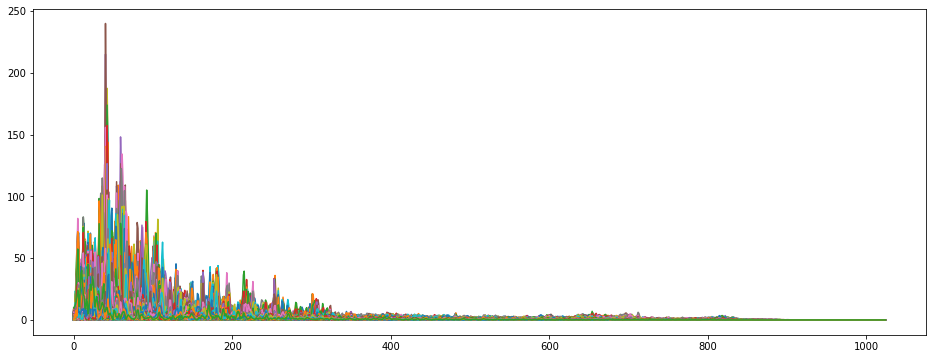

In [6]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)
# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))
print('Shape of D object:', np.shape(D))
plt.figure(figsize = (16, 6))
plt.plot(D);

**The Spectrogram**

What is a spectrogram? A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams (wiki).
Here we convert the frequency axis to a logarithmic one.



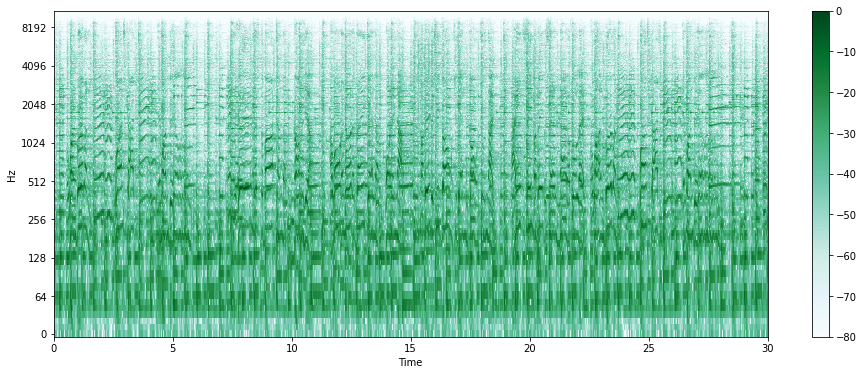

In [7]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'BuGn')
plt.colorbar();


## Mel Spectrogram

* The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram, but with a Mel Scale on the y axis.



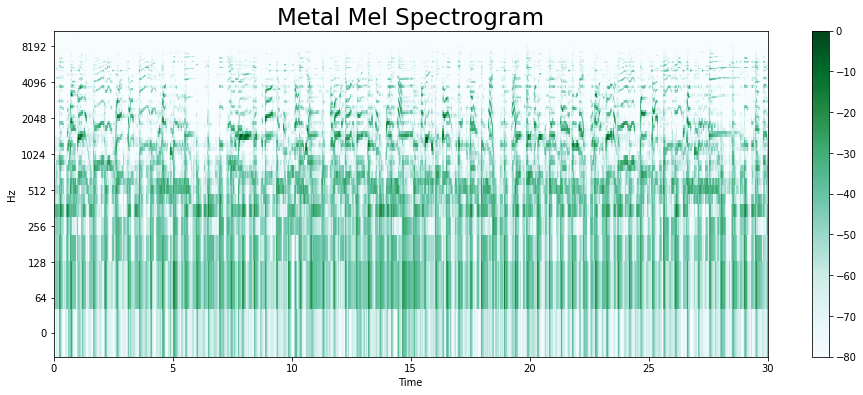

In [8]:
y, sr = librosa.load(EXAMPLE_FILE)
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'BuGn');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

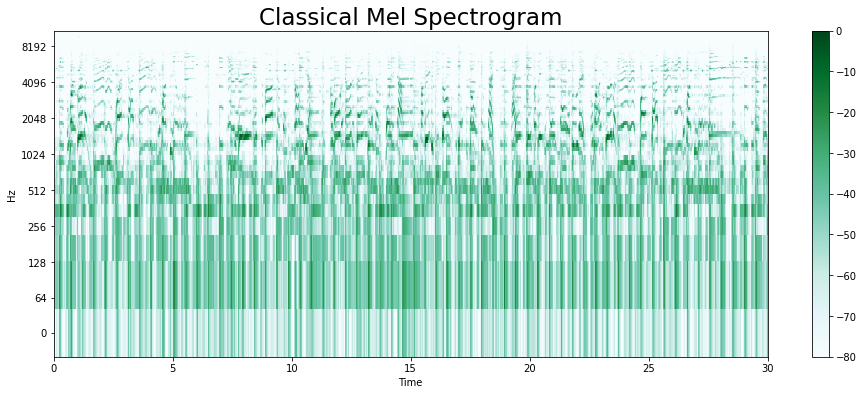

In [9]:
y, sr = librosa.load(EXAMPLE_FILE)
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log', cmap = 'BuGn');
plt.colorbar();
plt.title("Classical Mel Spectrogram", fontsize = 23);

## 2.2 Data Augmentation 

In [12]:
def reset_augmentation():
    # Remvoe folder and create empty folder 
    if os.path.exists(DATA_GEN_DIR): 
        shutil.rmtree(DATA_GEN_DIR, ignore_errors=True)
    os.makedirs(DATA_GEN_DIR)
    
def remove_corrupted_file(file_dir):
    if os.path.exists(file_dir): 
        os.remove(file_dir, ignore_errors=True)
    
def reset_train_test():
    training_set = os.path.join(TRAIN_DIR, category)
    testing_set = os.path.join(TEST_DIR, category) 
    validation_set = os.path.join(VALIDATE_DIR, category)
    
    os.makedirs(training_set)
    os.makedirs(testing_set)
    os.makedirs(validation_set)
    
def is_audio_file(audio_dir):
    return audio_dir.lower().endswith(('aifc', 'aiff', 'au', 'hcom', 'sndr', 'sndt', 'voc', 'wav', '8svx', 'sb', 'ub', 'ul'))

def random_uniuqe_audio_name():
    return f'{datetime.timestamp(datetime.now())}_{random.randint(-10000,10000)}.wav'

def audio_augmentation(file_path, save_path):
    for _ in range(AUGMENTATION_MULTIPLIER):
        try:
            augmenter = Compose([
                TimeStretch(min_rate=0.8, max_rate=1.25, p=0.20), 
                Shift(min_fraction=-0.5, max_fraction=0.5, p=0.10), 
                PitchShift(min_semitones=-4, max_semitones=4, p=0.20), 
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.10),
                ApplyImpulseResponse( p=0.10,leave_length_unchanged=False, ir_path=AUGMENTATION_IMPULSE_PATH  ),
                
                # Filters
                BandPassFilter(p=0.2),
                BandStopFilter(p=0.1),
                HighPassFilter(p=0.2),
                HighShelfFilter(p=0.1),
                LowPassFilter(p=0.3),
                LowShelfFilter(p=0.21), 
                PeakingFilter(p=0.4),
                
                SevenBandParametricEQ(p=0.2),
                PolarityInversion(p=0.2),
                Gain(min_gain_in_db=-12, max_gain_in_db=12, p=0.1),
                TimeMask(p=0.14),
            ])
            save_file_path = os.path.join(save_path, random_uniuqe_audio_name() )
            sound_file, sr = librosa.load(file_path)
            augmented_samples = augmenter(samples=sound_file, sample_rate=sr)
            sf.write(save_file_path , augmented_samples, sr , 'PCM_16')
        except:
            remove_corrupted_file(file_path)
            continue
        
        
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


def concatinate_tensors(arr):
    val = arr[0]
    for value in arr[1:]:
        val.concatenate(value)
    val = val.shuffle(1234)
    return val 

In [13]:
reset_augmentation()

# Train 80% , Test 20%
for idx,category in enumerate(CLASSES):
    
    print(category)
    
    # path to the image
    audio_path = os.path.join(DATA_DIR,category )
    list_audio = os.listdir(audio_path ) 
    
    train_count = int(len(list_audio)*0.70)
    test_count = int(len(list_audio)*0.20)
    
    train_audio = list_audio[:train_count]
    test_audio = list_audio[train_count:train_count+test_count]
    validation_audio = list_audio[train_count+test_count:]
    reset_train_test()
    
    for train_audio_name in train_audio:
        train_audio_dir = os.path.join( audio_path ,train_audio_name)
        
        # Check if Audio
        if is_audio_file(train_audio_dir):
            
            # Augment the train sound 
            save_dir = os.path.join(TRAIN_DIR, category)
            audio_augmentation(train_audio_dir,save_dir)
            
            # Copy the file to generated file 
            copy_dir = os.path.join(TRAIN_DIR, category, random_uniuqe_audio_name())
            shutil.copy2(train_audio_dir, copy_dir )
            
    for test_audio_name in test_audio:
        test_audio_dir = os.path.join( audio_path ,test_audio_name)
        
        # Check if Audio
        if is_audio_file(test_audio_dir):
            
            # Augment the test sound 
            save_dir = os.path.join(TEST_DIR, category)
            audio_augmentation(test_audio_dir,save_dir)
            
            # Copy the file to generated file 
            copy_dir = os.path.join(TEST_DIR, category, random_uniuqe_audio_name())
            shutil.copy2(test_audio_dir, copy_dir )

    for validation_audio_name in validation_audio:
        validation_audio_dir = os.path.join( audio_path , validation_audio_name)
        
        # Check if Audio
        if is_audio_file(validation_audio_dir):
            
            # Augment the test sound 
            save_dir = os.path.join(VALIDATE_DIR, category)
            audio_augmentation(validation_audio_dir,save_dir)
            
            # Copy the file to generated file 
            copy_dir = os.path.join(VALIDATE_DIR, category, random_uniuqe_audio_name())
            shutil.copy2( validation_audio_dir, copy_dir )

reggae
metal
disco
pop
blues
hiphop
classical
rock
country
jazz


In [14]:

train_c, test_c, val_c = [],[],[]
for cols in CLASSES:
    train_c.append( len( os.listdir(os.path.join(TRAIN_DIR,cols))) )
    test_c.append( len( os.listdir(os.path.join(TEST_DIR,cols))) )
    val_c.append( len( os.listdir(os.path.join(VALIDATE_DIR,cols))) )
        
train_test_val = pd.DataFrame({'class':CLASSES,'train':train_c,'test': test_c, 'validation': val_c})
train_test_val

class  train  test  validation
0     reggae    770   220         110
1      metal    770   220         110
2      disco    770   220         110
3        pop    770   220         110
4      blues    770   220         110
5     hiphop    770   220         110
6  classical    770   220         110
7       rock    770   220         110
8    country    770   220         110
9       jazz    759   209         121

In [15]:
print('train : ', sum(train_test_val['train']))
print('test : ', sum(train_test_val['test']))
print('validation : ', sum(train_test_val['validation']))

train :  7689
test :  2189
validation :  1111


## 2.3 Data Transformation

In [16]:
# Load up the dataset
train_dataset = [
    tf.data.Dataset.list_files( os.path.join(os.path.join(TRAIN_DIR, i),'*.wav') ) 
    for i in CLASSES
]

test_dataset = [
    tf.data.Dataset.list_files( os.path.join(os.path.join(TEST_DIR, i),'*.wav') ) 
    for i in CLASSES
]

validation_dataset = [
    tf.data.Dataset.list_files( os.path.join(os.path.join(VALIDATE_DIR, i),'*.wav') ) 
    for i in CLASSES
]

# Load give labels
train_dataset_lbl = [
    tf.data.Dataset.zip(  (val, tf.data.Dataset.from_tensor_slices(  tf.ones(len(val))*idx))  ) 
    for idx,val in enumerate(train_dataset)
]
test_dataset_lbl = [
    tf.data.Dataset.zip(  (val, tf.data.Dataset.from_tensor_slices(  tf.ones(len(val))*idx))  ) 
    for idx,val in enumerate(test_dataset)
]
validation_dataset_lbl = [
    tf.data.Dataset.zip(  (val, tf.data.Dataset.from_tensor_slices(  tf.ones(len(val))*idx))  ) 
    for idx,val in enumerate(validation_dataset)
]
[i.as_numpy_iterator().next() for i in train_dataset_lbl]

2022-05-30 20:12:16.904658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zalven/anaconda3/envs/music-genre/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-30 20:12:16.905153: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 20:12:16.905820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zalven-Nitro-AN515-55): /proc/driver/nvidia/version does not exist
2022-05-30 20:12:16.920976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

[(b'dataset/train/reggae/1653896031.473845_5364.wav', 0.0),
 (b'dataset/train/metal/1653896567.942488_726.wav', 1.0),
 (b'dataset/train/disco/1653897109.847782_2853.wav', 2.0),
 (b'dataset/train/pop/1653897949.807222_-6642.wav', 3.0),
 (b'dataset/train/blues/1653898887.803247_6005.wav', 4.0),
 (b'dataset/train/hiphop/1653899278.642328_2194.wav', 5.0),
 (b'dataset/train/classical/1653899639.027283_7919.wav', 6.0),
 (b'dataset/train/rock/1653900168.659507_-7916.wav', 7.0),
 (b'dataset/train/country/1653900587.450724_-6847.wav', 8.0),
 (b'dataset/train/jazz/1653900794.749255_-4903.wav', 9.0)]

In [97]:
train_data = concatinate_tensors(train_dataset_lbl)
test_data = concatinate_tensors(test_dataset_lbl)
validation_data = concatinate_tensors(validation_dataset_lbl)

In [21]:
class_lengths = []
for classes in CLASSES:
    lengths = []
    sound_dir = os.path.join(TRAIN_DIR, classes) 
    for file in tqdm(os.listdir(sound_dir)):
        sound_path = os.path.join(sound_dir, file)
        tensor_wave = load_wav_16k_mono(sound_path)
        lengths.append(len(tensor_wave))
    class_lengths.append(lengths)

100%|██████████| 759/759 [01:12<00:00, 10.53it/s]


In [39]:
mean_len, min_len, max_len = [], [], []
for classes, value in zip(CLASSES,class_lengths):
    value = np.array(value)
    mean_len.append( np.mean(value) ) 
    min_len.append( value.min())
    max_len.append( np.max(value) )
    
dataset_analysis = pd.DataFrame({
    'Classes':CLASSES, 'Mean':  mean_len, 'Minimum':min_len, 'Maximum': max_len 
})

dataset_analysis.head()

Classes           Mean  Minimum  Maximum
0  reggae  480868.210390   480002   488997
1   metal  480832.697403   480002   488997
2   disco  481135.140260   479886   493442
3     pop  480755.000000   480002   488787
4   blues  481011.545455   480213   488997

In [53]:
print(f"Mean : {np.mean(dataset_analysis['Mean'])/16000} seconds")
print(f"Min : {np.min(dataset_analysis['Minimum'])/16000} seconds")
print(f"Max : {np.min(dataset_analysis['Maximum'])/16000} seconds")

Mean : 30.0725536954169 seconds
Min : 29.9319375 seconds
Max : 30.5491875 seconds


In [126]:
# COnvert Audio to spectogram to Mel Spectogram
def convert_mel_spectogram(file_dir, label):
    
    audio = tfio.IOTensor.graph(tf.int16).from_audio(file_dir)
    
    # Get audio 
    # audio = tfio.audio.AudioIOTensor(file_dir)
    audio_slice = audio[480002:]
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    tensor = tf.cast(audio_tensor, tf.float32)
    
    # Trim Noise 
    position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
    start = position[0]
    stop = position[1]
    processed = tensor[start:stop]
    
    # Fade In and Fade Out
    # One useful audio engineering technique is fade, 
    # which gradually increases or decreases audio signals. 
    # This can be done through tfio.audio.fade. tfio.audio.fade 
    # supports different shapes of fades such as linear, logarithmic, or exponential:
    fade = tfio.audio.fade( processed, fade_in=1000, fade_out=2000, mode="logarithmic")

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(fade, nfft=512, window=512, stride=256)
    
    # Convert to mel spectogram 
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
    
    # Convert to db scale mel-spectrogram
    dbscale_mel_spectrogram = tfio.audio.dbscale( mel_spectrogram, top_db=80)

    return dbscale_mel_spectrogram, label

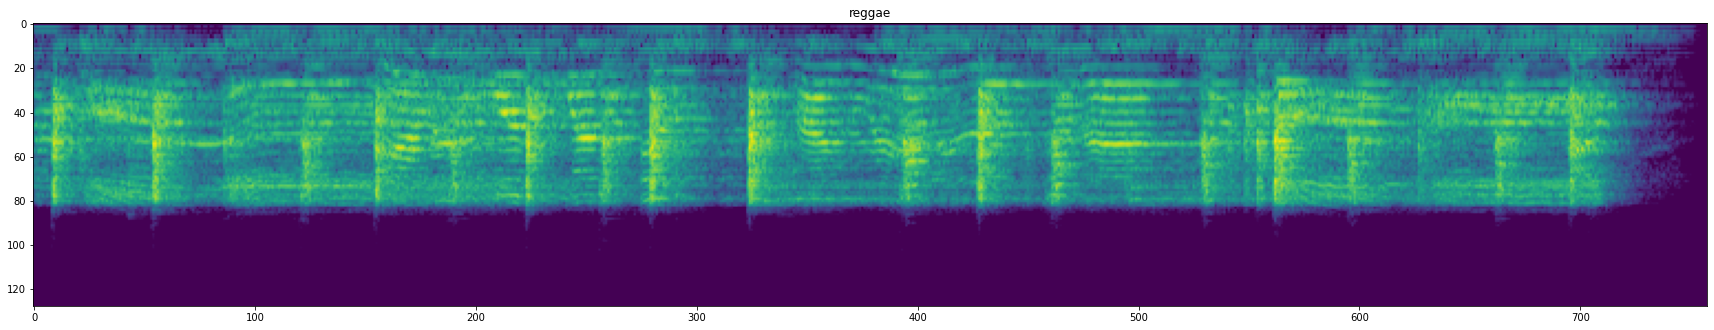

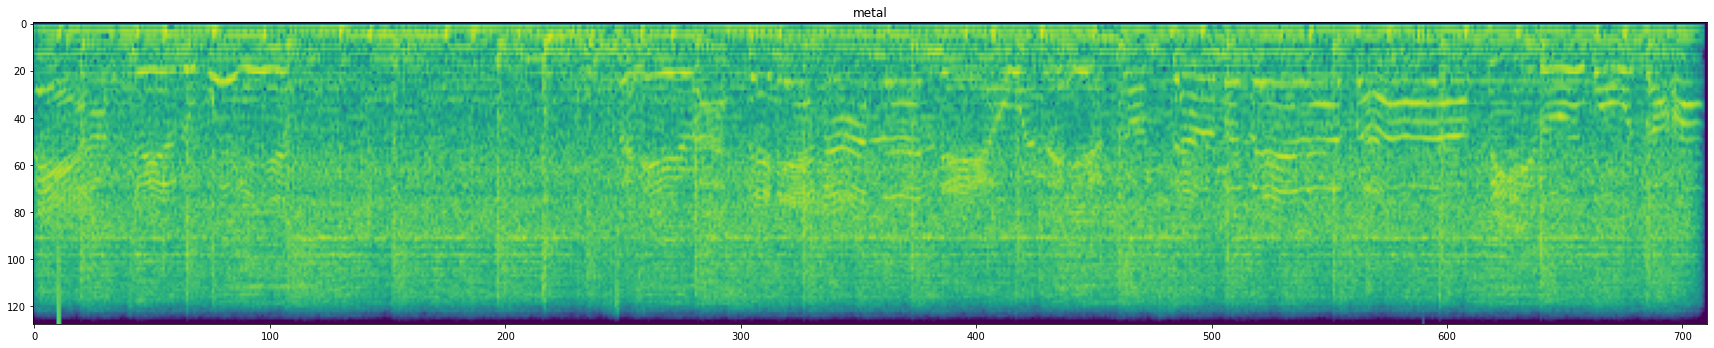

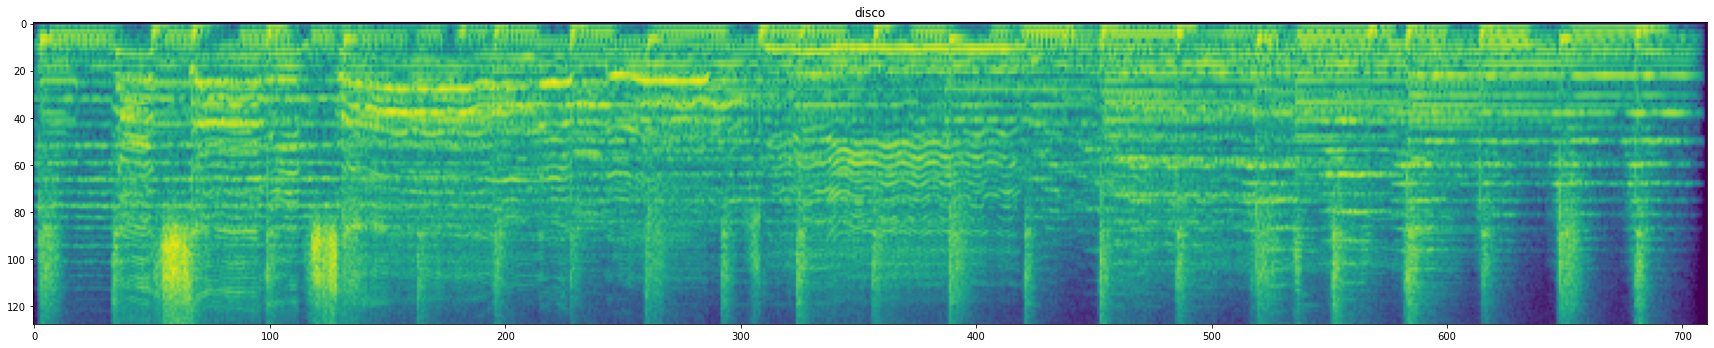

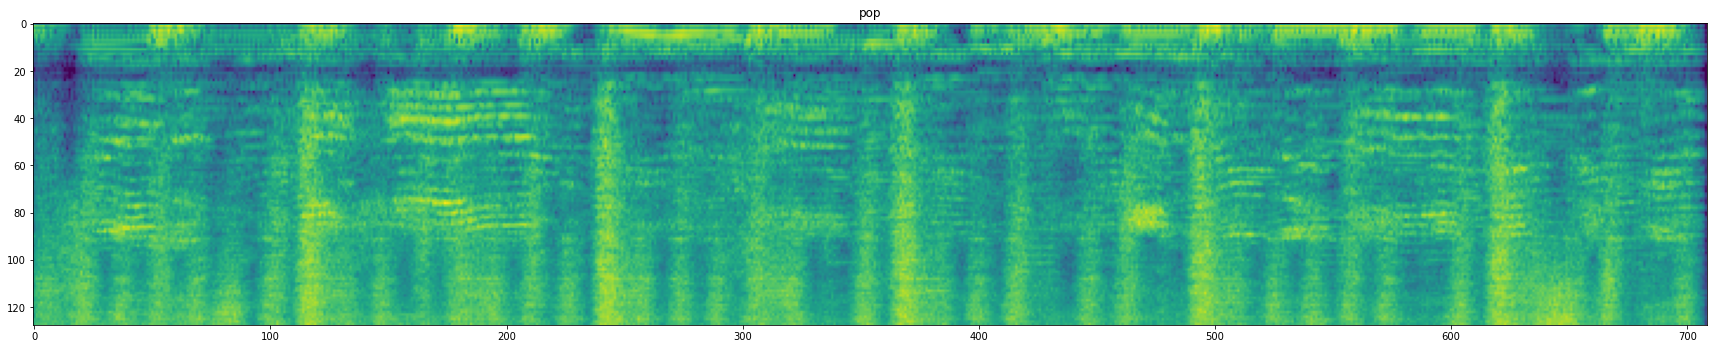

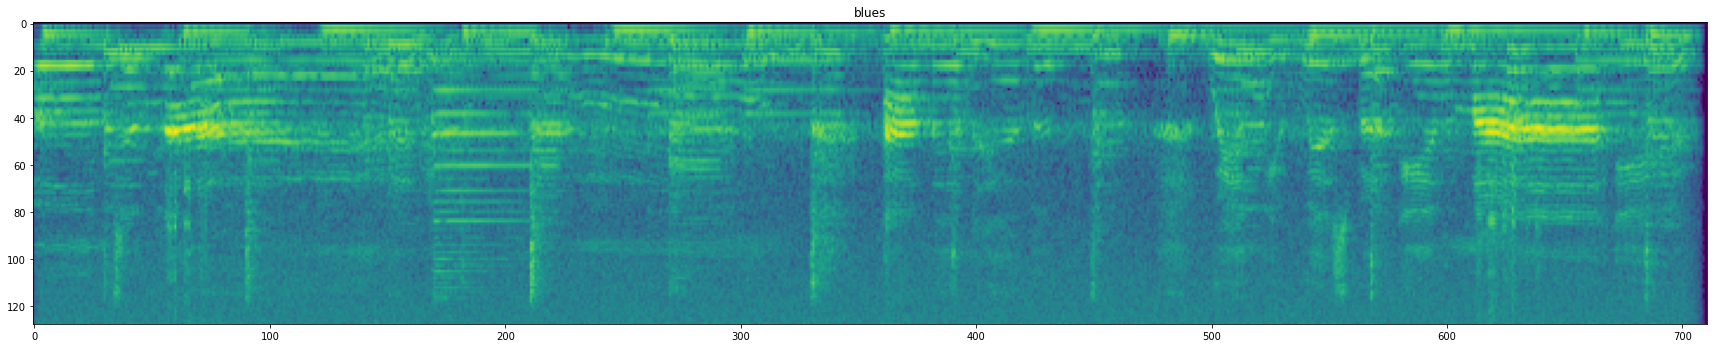

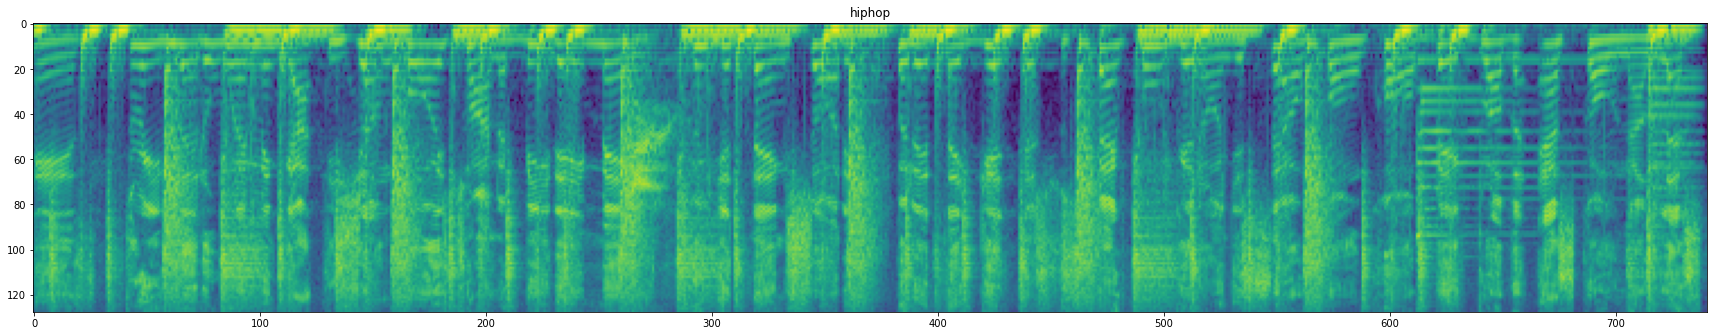

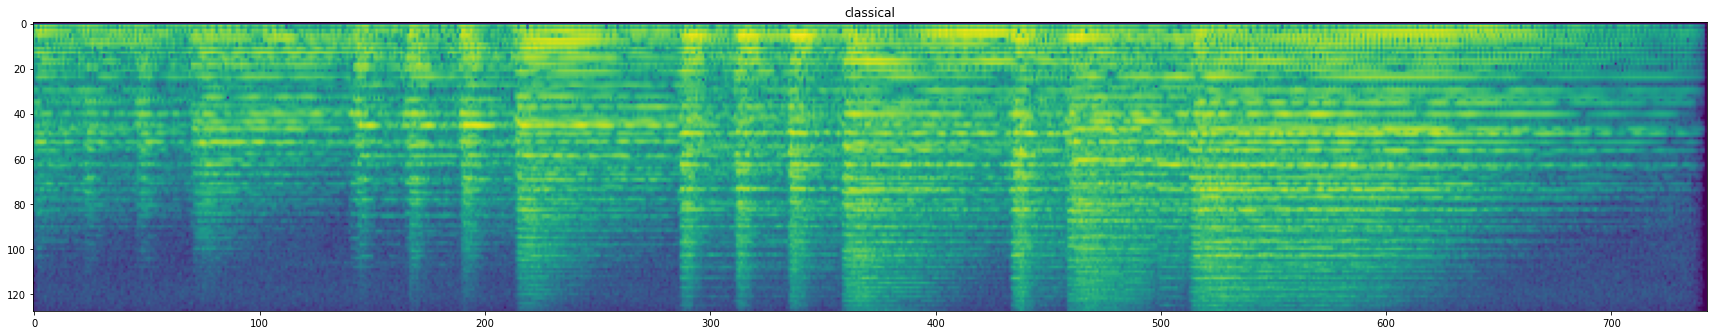

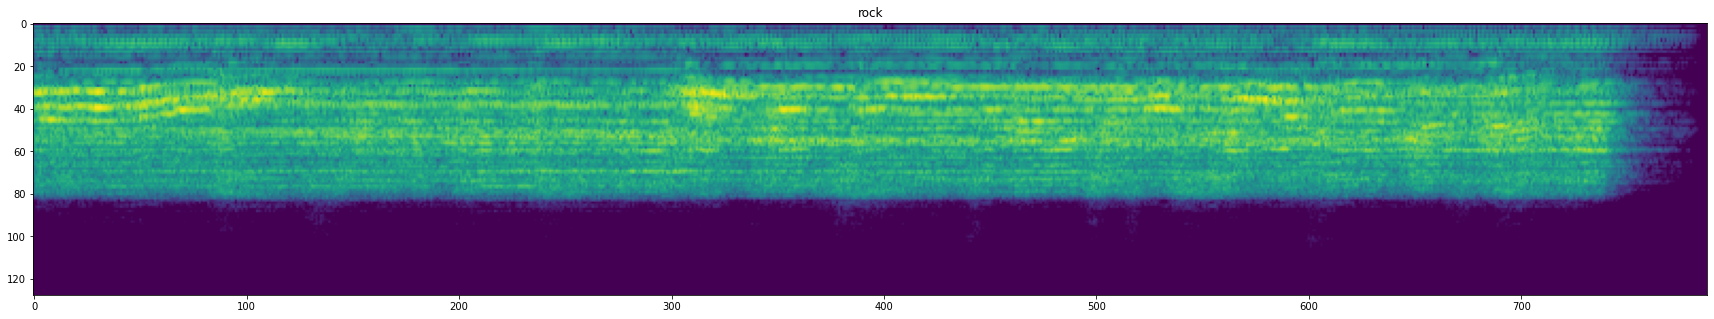

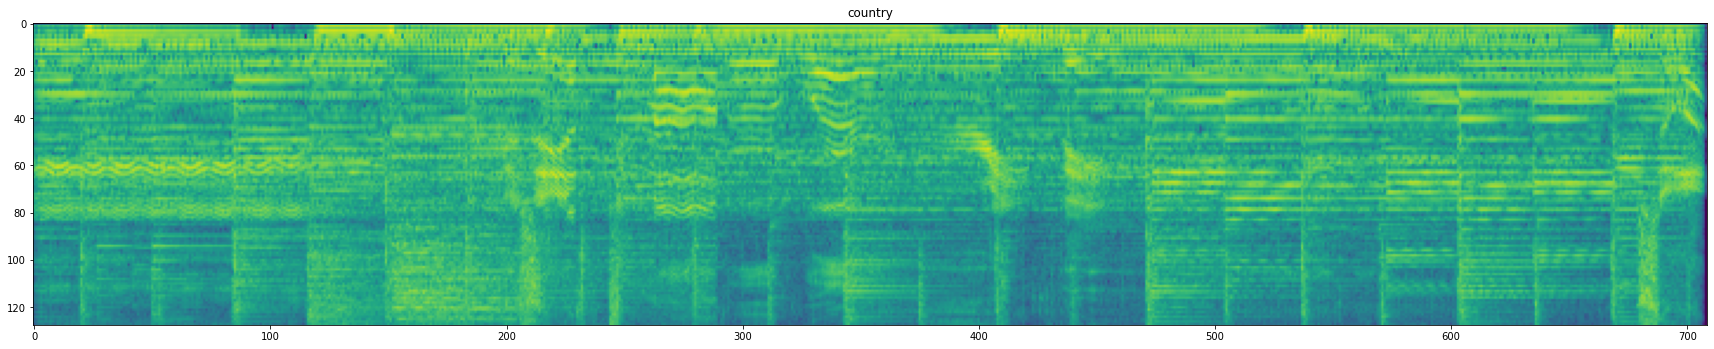

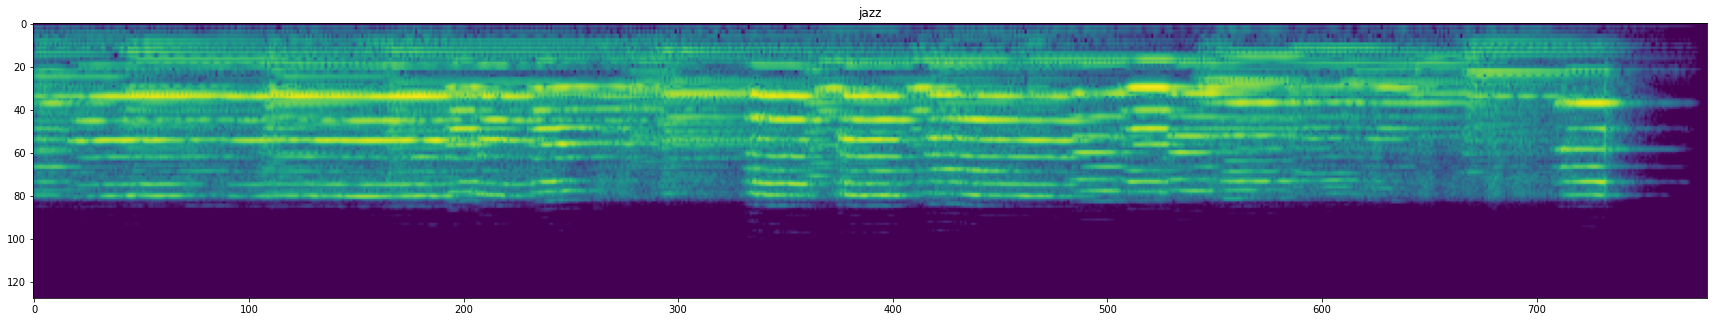

In [123]:
# example_spectogram, example_label  =convert_mel_spectogram(EXAMPLE_FILE,0)

for idx,classes in enumerate(CLASSES):
    path_file = os.path.join( TRAIN_DIR,classes)
    example_file = random.choice(os.listdir(path_file))
    example_audio = os.path.join(path_file ,example_file)
    example_spectogram, example_label  =convert_mel_spectogram( example_audio ,0)
    plt.figure(figsize=(30,20))
    plt.title(classes)
    plt.imshow(tf.transpose(example_spectogram))

# 2.4 Create Data Pipeline

In [130]:
def data_pipeline(data):
    data = data.map(convert_mel_spectogram)
    data = data.cache()
    data = data.shuffle(buffer_size=1000)
    data = data.batch(32)
    data = data.prefetch(8)
    return data 

training_data_mel = data_pipeline(train_data)
testing_data_mel = data_pipeline(test_data)
validation_data_mel = data_pipeline(validation_data)